# SAC Training Logs Visualization

This notebook loads and visualizes the training logs from TensorBoard event files and evaluation data for SAC reinforcement learning experiments on Dymonopoly.

## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Define paths
LOGS_DIR = "logs"
SAC_1_DIR = os.path.join(LOGS_DIR, "SAC_1")
SAC_2_DIR = os.path.join(LOGS_DIR, "SAC_2")
EVAL_FILE = os.path.join(LOGS_DIR, "evaluations.npz")

print("Logs directory contents:")
for item in os.listdir(LOGS_DIR):
    print(f"  - {item}")

Logs directory contents:
  - evaluations.npz
  - SAC_1
  - SAC_2


## 2. Load TensorBoard Event Files

Load the TensorBoard event files from SAC_1 and SAC_2 directories using EventAccumulator.

In [2]:
def load_tensorboard_logs(log_dir):
    """Load TensorBoard event files and return an EventAccumulator."""
    # Find the event file in the directory
    event_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]
    if not event_files:
        print(f"No event files found in {log_dir}")
        return None
    
    event_path = os.path.join(log_dir, event_files[0])
    print(f"Loading: {event_path}")
    
    # Load the event accumulator
    ea = EventAccumulator(event_path)
    ea.Reload()
    
    return ea

# Load both SAC runs
print("Loading SAC_1 logs...")
ea_sac1 = load_tensorboard_logs(SAC_1_DIR)

print("\nLoading SAC_2 logs...")
ea_sac2 = load_tensorboard_logs(SAC_2_DIR)

Loading SAC_1 logs...
Loading: logs\SAC_1\events.out.tfevents.1764313269.Haris.13748.0

Loading SAC_2 logs...
Loading: logs\SAC_2\events.out.tfevents.1764348897.Haris.9980.0


## 3. Parse and Extract Scalar Data from Events

Extract all available scalar metrics from the TensorBoard logs into pandas DataFrames.

In [3]:
def extract_scalars(ea, tag):
    """Extract scalar values for a given tag into a DataFrame."""
    if ea is None or tag not in ea.Tags()['scalars']:
        return pd.DataFrame()
    
    events = ea.Scalars(tag)
    df = pd.DataFrame({
        'step': [e.step for e in events],
        'value': [e.value for e in events],
        'wall_time': [e.wall_time for e in events]
    })
    return df

def get_all_scalars(ea, name=""):
    """Get all available scalar tags and their data."""
    if ea is None:
        return {}
    
    tags = ea.Tags()['scalars']
    print(f"\n{name} Available scalar tags ({len(tags)}):")
    for tag in tags:
        print(f"  - {tag}")
    
    return {tag: extract_scalars(ea, tag) for tag in tags}

# Extract all scalars from both runs
sac1_scalars = get_all_scalars(ea_sac1, "SAC_1")
sac2_scalars = get_all_scalars(ea_sac2, "SAC_2")


SAC_1 Available scalar tags (10):
  - rollout/ep_len_mean
  - rollout/ep_rew_mean
  - time/fps
  - train/actor_loss
  - train/critic_loss
  - train/ent_coef
  - train/ent_coef_loss
  - train/learning_rate
  - eval/mean_ep_length
  - eval/mean_reward

SAC_2 Available scalar tags (10):
  - rollout/ep_len_mean
  - rollout/ep_rew_mean
  - time/fps
  - train/actor_loss
  - train/critic_loss
  - train/ent_coef
  - train/ent_coef_loss
  - train/learning_rate
  - eval/mean_ep_length
  - eval/mean_reward


## 4. Load Evaluation Data from NPZ File

Load the evaluation results from the `evaluations.npz` file.

In [4]:
# Load evaluation data
eval_data = np.load(EVAL_FILE)

print("Evaluation data contents:")
for key in eval_data.files:
    arr = eval_data[key]
    print(f"  - {key}: shape={arr.shape}, dtype={arr.dtype}")

# Extract arrays
timesteps = eval_data['timesteps']
results = eval_data['results']
ep_lengths = eval_data['ep_lengths']

print(f"\nTimesteps: {timesteps}")
print(f"Results shape: {results.shape} (timesteps x episodes)")
print(f"Episode lengths shape: {ep_lengths.shape}")

Evaluation data contents:
  - timesteps: shape=(100,), dtype=int64
  - results: shape=(100, 5), dtype=float64
  - ep_lengths: shape=(100, 5), dtype=int64

Timesteps: [  10000   20000   30000   40000   50000   60000   70000   80000   90000
  100000  110000  120000  130000  140000  150000  160000  170000  180000
  190000  200000  210000  220000  230000  240000  250000  260000  270000
  280000  290000  300000  310000  320000  330000  340000  350000  360000
  370000  380000  390000  400000  410000  420000  430000  440000  450000
  460000  470000  480000  490000  500000  510000  520000  530000  540000
  550000  560000  570000  580000  590000  600000  610000  620000  630000
  640000  650000  660000  670000  680000  690000  700000  710000  720000
  730000  740000  750000  760000  770000  780000  790000  800000  810000
  820000  830000  840000  850000  860000  870000  880000  890000  900000
  910000  920000  930000  940000  950000  960000  970000  980000  990000
 1000000]
Results shape: (100, 

## 5. Plot Training Metrics from SAC_1

Visualize the key training metrics from the first SAC run.

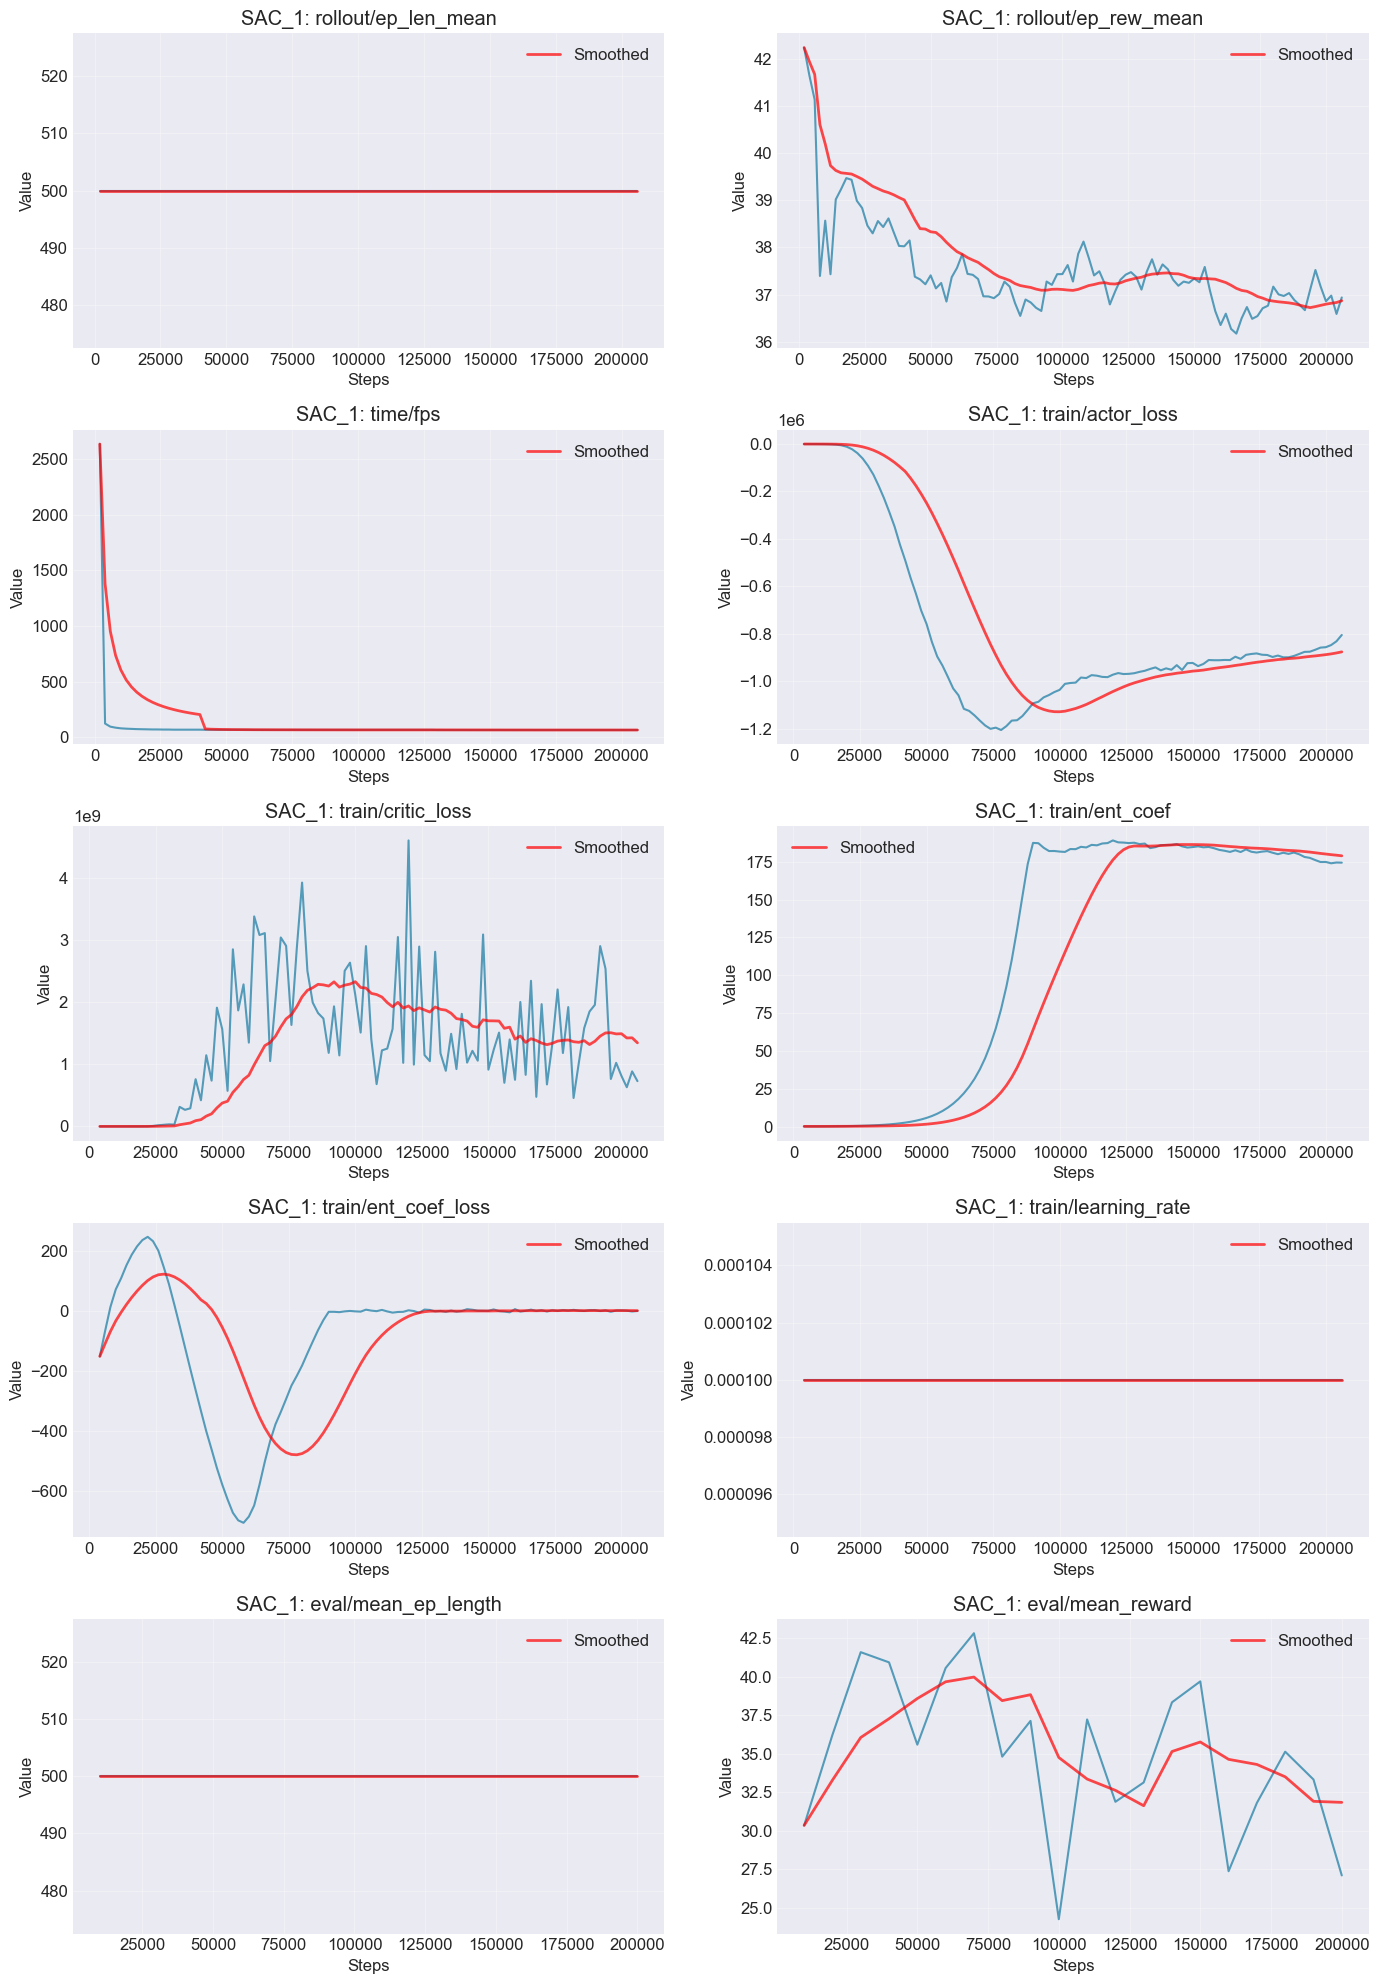

In [5]:
def plot_metrics(scalars_dict, title_prefix="", color='blue'):
    """Plot all available metrics from a scalars dictionary."""
    if not scalars_dict:
        print("No data to plot")
        return
    
    n_metrics = len(scalars_dict)
    if n_metrics == 0:
        print("No metrics found")
        return
    
    # Calculate grid size
    n_cols = min(2, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (tag, df) in enumerate(scalars_dict.items()):
        if df.empty:
            continue
        ax = axes[idx]
        ax.plot(df['step'], df['value'], color=color, linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Value')
        ax.set_title(f"{title_prefix}{tag}")
        ax.grid(True, alpha=0.3)
        
        # Add smoothed line
        if len(df) > 10:
            window = min(50, len(df) // 5)
            smoothed = df['value'].rolling(window=window, min_periods=1).mean()
            ax.plot(df['step'], smoothed, color='red', linewidth=2, alpha=0.7, label='Smoothed')
            ax.legend()
    
    # Hide empty subplots
    for idx in range(len(scalars_dict), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot SAC_1 metrics
if sac1_scalars:
    plot_metrics(sac1_scalars, "SAC_1: ", color='#2E86AB')
else:
    print("No SAC_1 data available")

## 6. Plot Training Metrics from SAC_2

Visualize the key training metrics from the second SAC run.

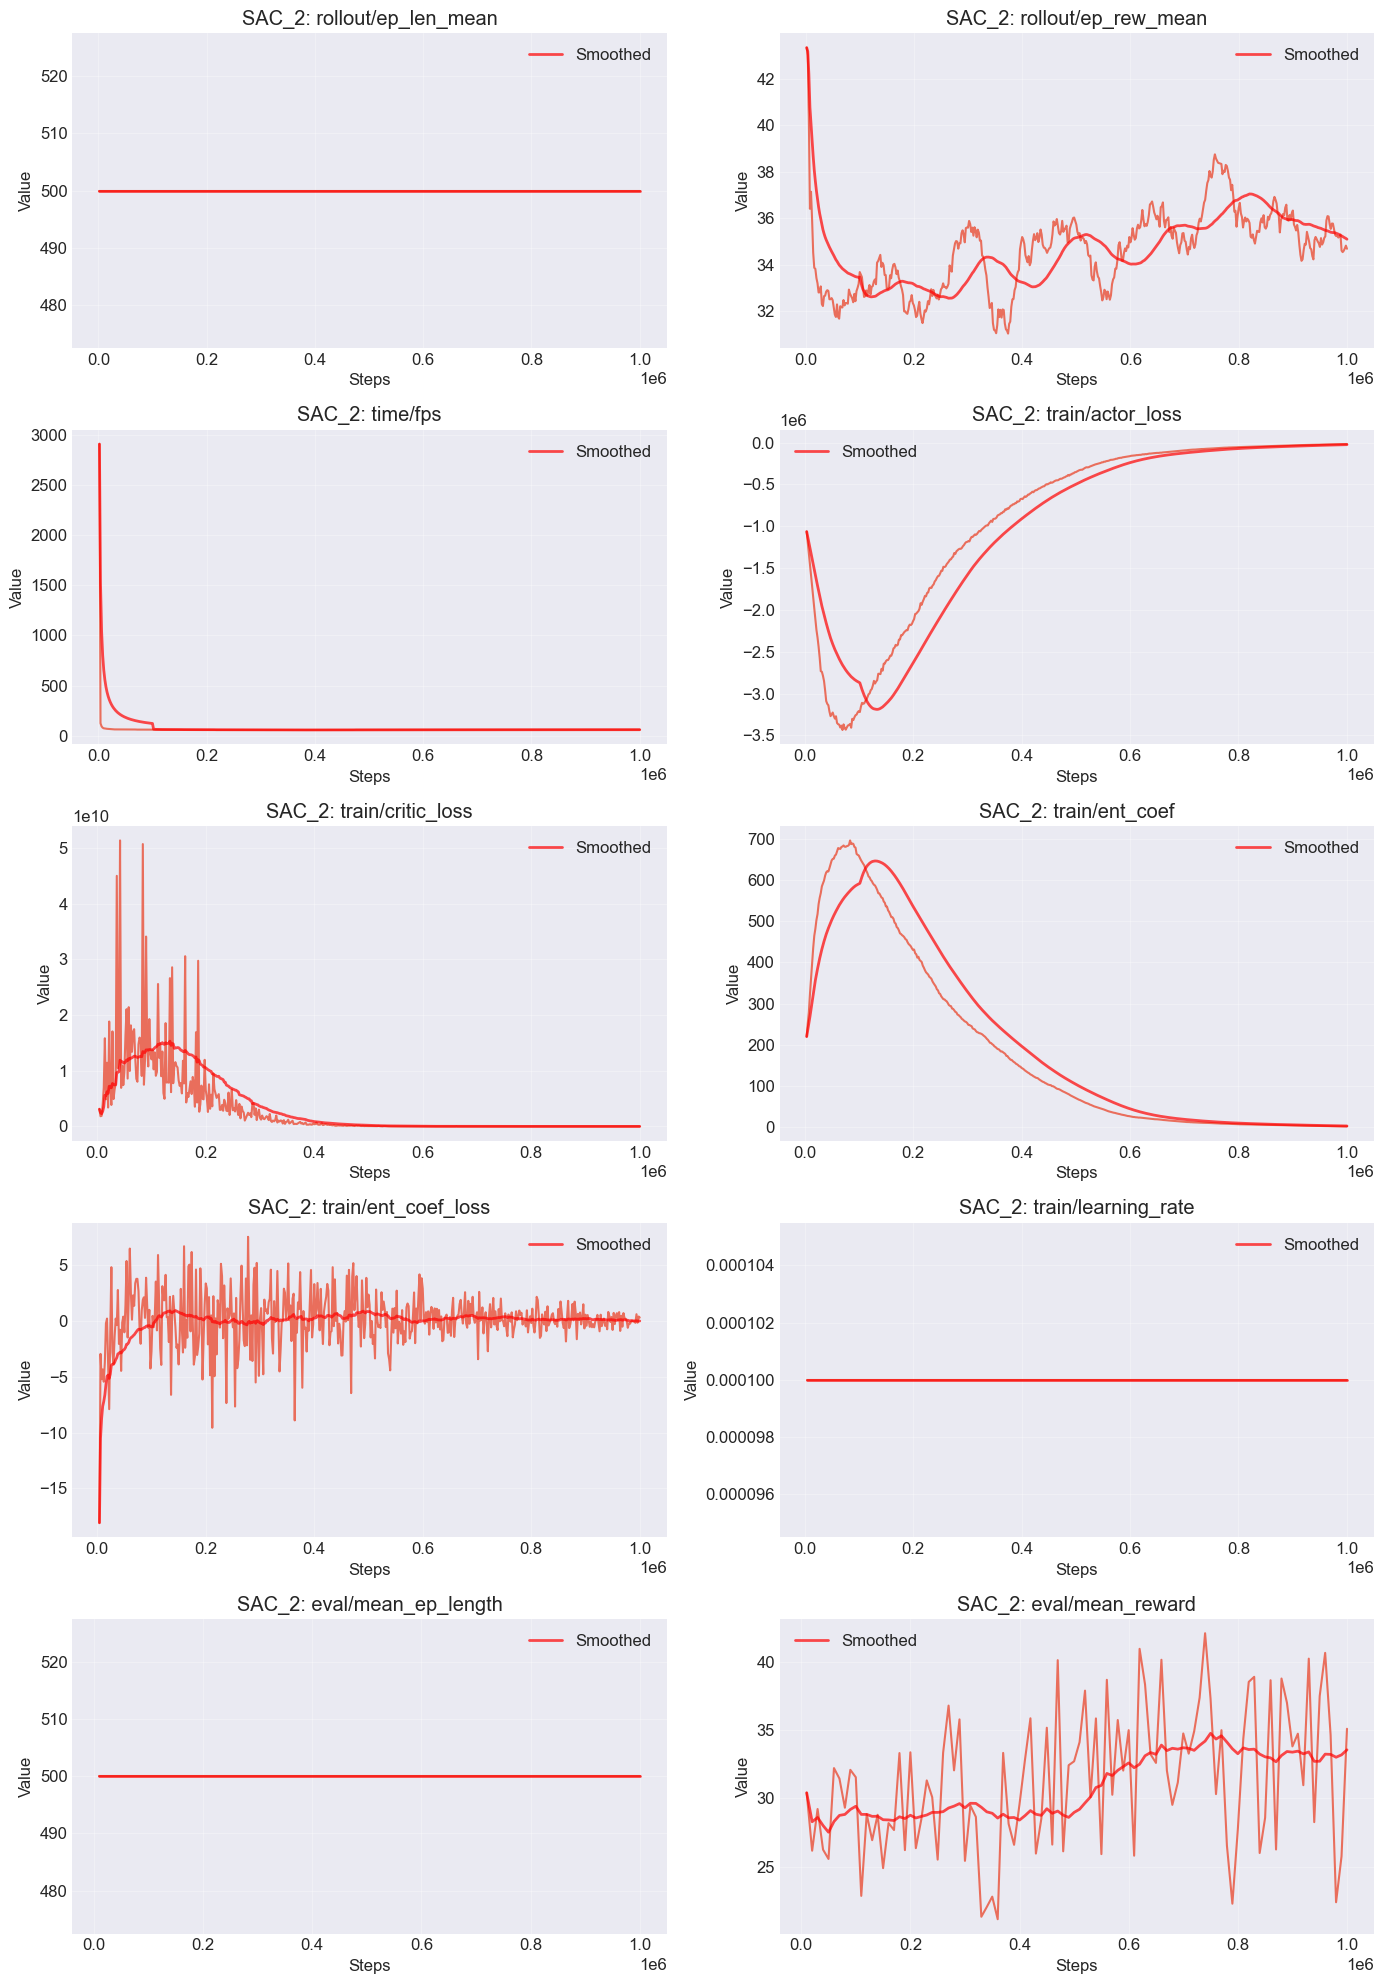

In [6]:
# Plot SAC_2 metrics
if sac2_scalars:
    plot_metrics(sac2_scalars, "SAC_2: ", color='#E94F37')
else:
    print("No SAC_2 data available")

## 7. Compare SAC_1 vs SAC_2 Performance

Create overlay plots to compare the performance of both SAC runs.

Common tags between SAC_1 and SAC_2: {'time/fps', 'train/ent_coef', 'train/ent_coef_loss', 'train/critic_loss', 'rollout/ep_len_mean', 'eval/mean_ep_length', 'eval/mean_reward', 'train/actor_loss', 'rollout/ep_rew_mean', 'train/learning_rate'}


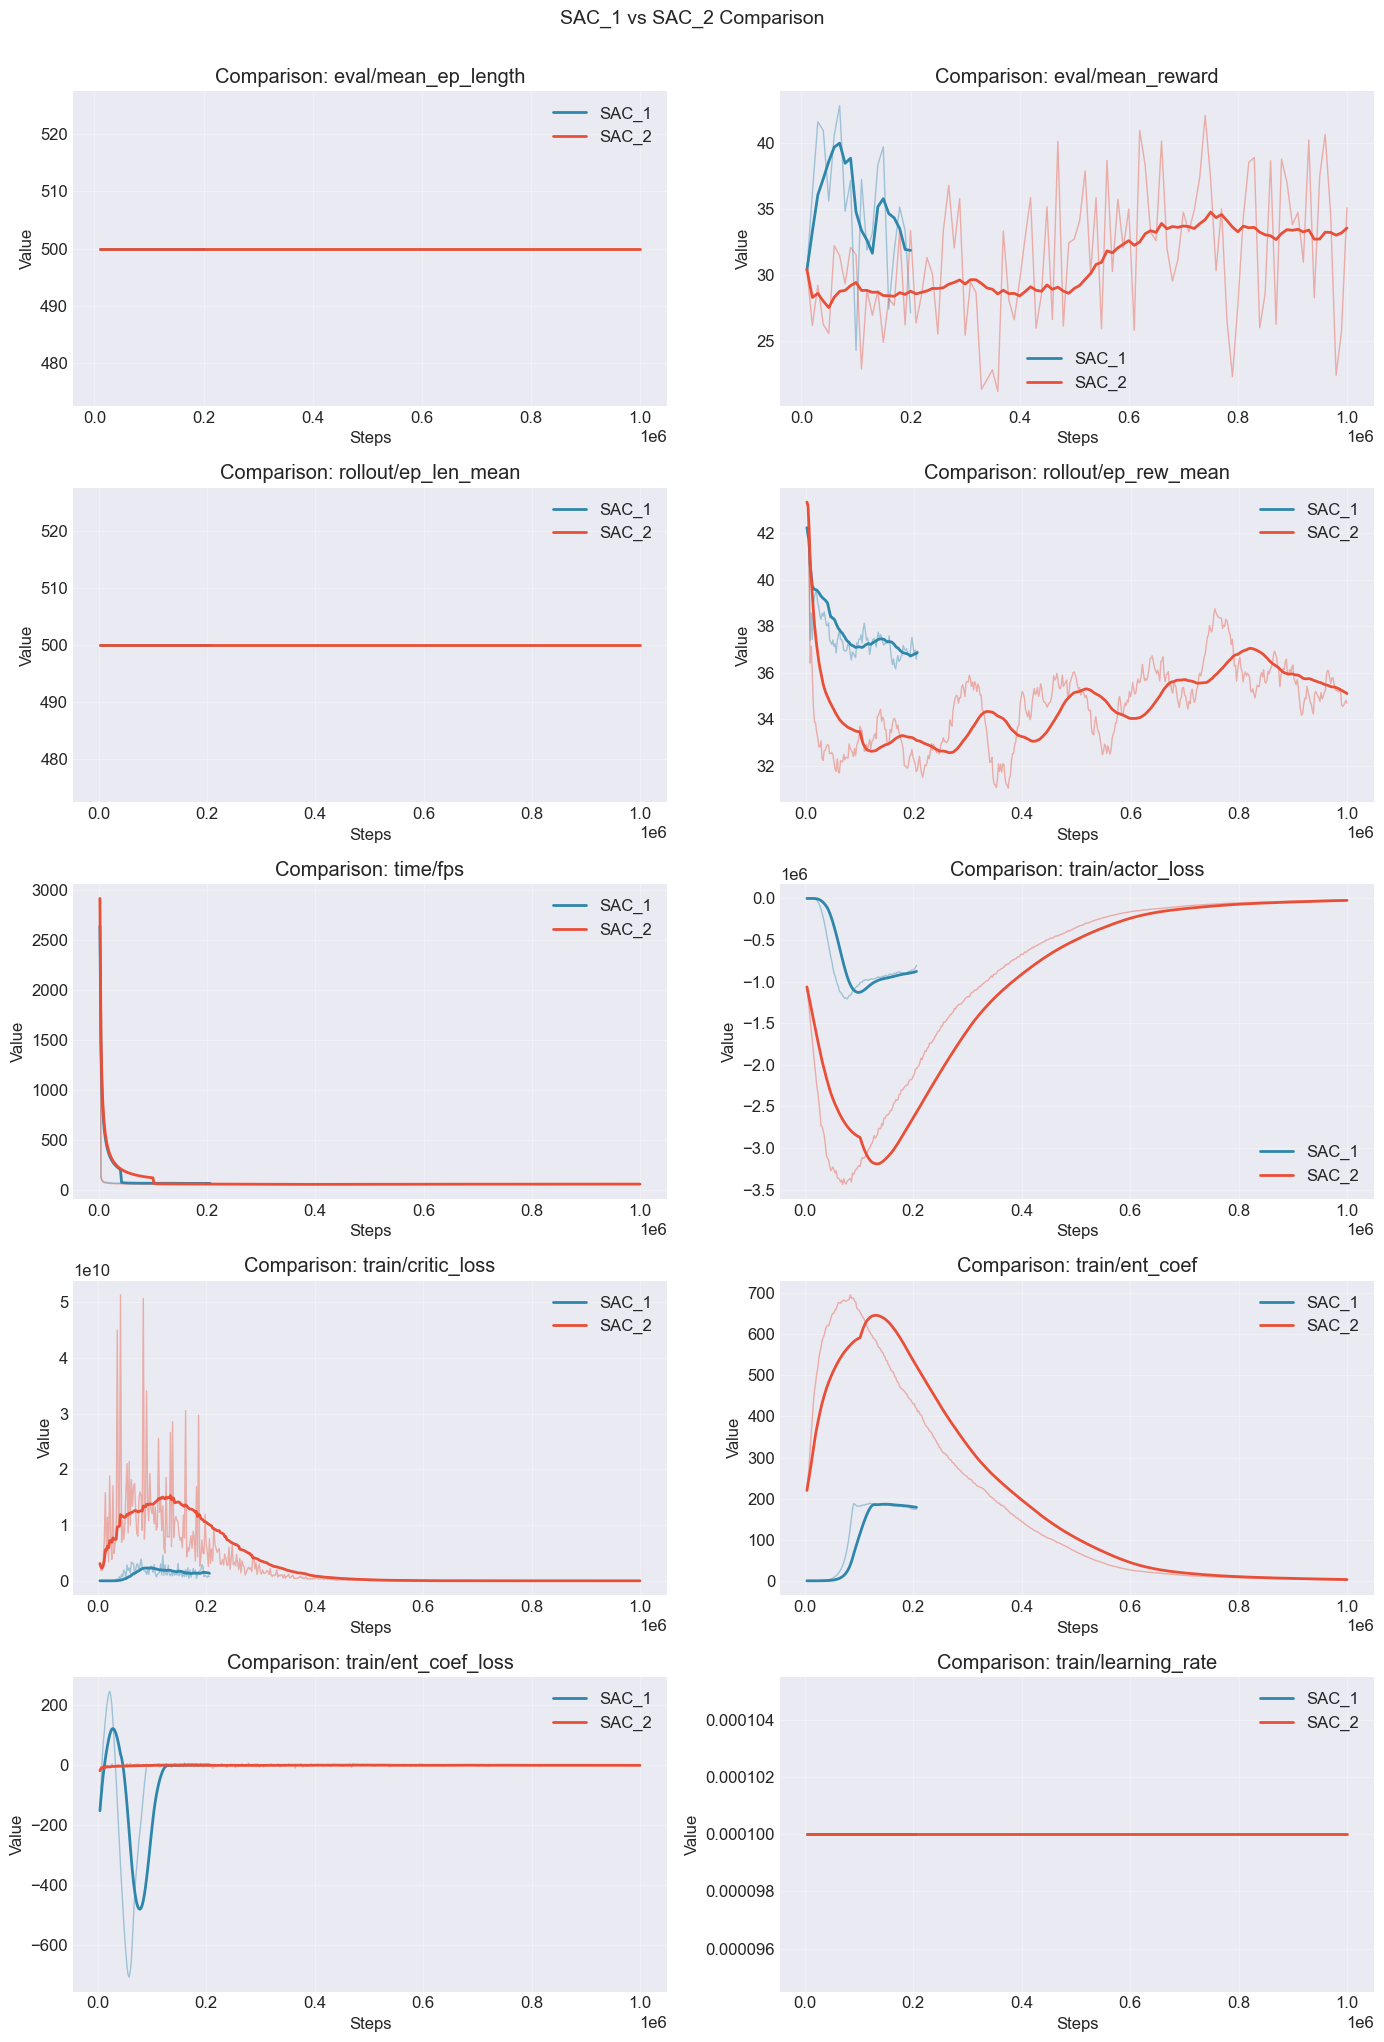

In [7]:
# Find common tags between SAC_1 and SAC_2
common_tags = set(sac1_scalars.keys()) & set(sac2_scalars.keys())
print(f"Common tags between SAC_1 and SAC_2: {common_tags}")

if common_tags:
    n_common = len(common_tags)
    n_cols = min(2, n_common)
    n_rows = (n_common + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    if n_common == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_common > 1 else [axes]
    
    for idx, tag in enumerate(sorted(common_tags)):
        ax = axes[idx]
        
        df1 = sac1_scalars[tag]
        df2 = sac2_scalars[tag]
        
        if not df1.empty:
            ax.plot(df1['step'], df1['value'], color='#2E86AB', alpha=0.4, linewidth=1)
            # Smoothed
            if len(df1) > 10:
                window = min(50, len(df1) // 5)
                smoothed1 = df1['value'].rolling(window=window, min_periods=1).mean()
                ax.plot(df1['step'], smoothed1, color='#2E86AB', linewidth=2, label='SAC_1')
        
        if not df2.empty:
            ax.plot(df2['step'], df2['value'], color='#E94F37', alpha=0.4, linewidth=1)
            # Smoothed
            if len(df2) > 10:
                window = min(50, len(df2) // 5)
                smoothed2 = df2['value'].rolling(window=window, min_periods=1).mean()
                ax.plot(df2['step'], smoothed2, color='#E94F37', linewidth=2, label='SAC_2')
        
        ax.set_xlabel('Steps')
        ax.set_ylabel('Value')
        ax.set_title(f"Comparison: {tag}")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(common_tags), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle("SAC_1 vs SAC_2 Comparison", fontsize=14, y=1.02)
    plt.show()
else:
    print("No common tags found between SAC_1 and SAC_2")

## 8. Plot Evaluation Results

Visualize the evaluation results showing mean rewards and episode lengths over training timesteps with confidence intervals.

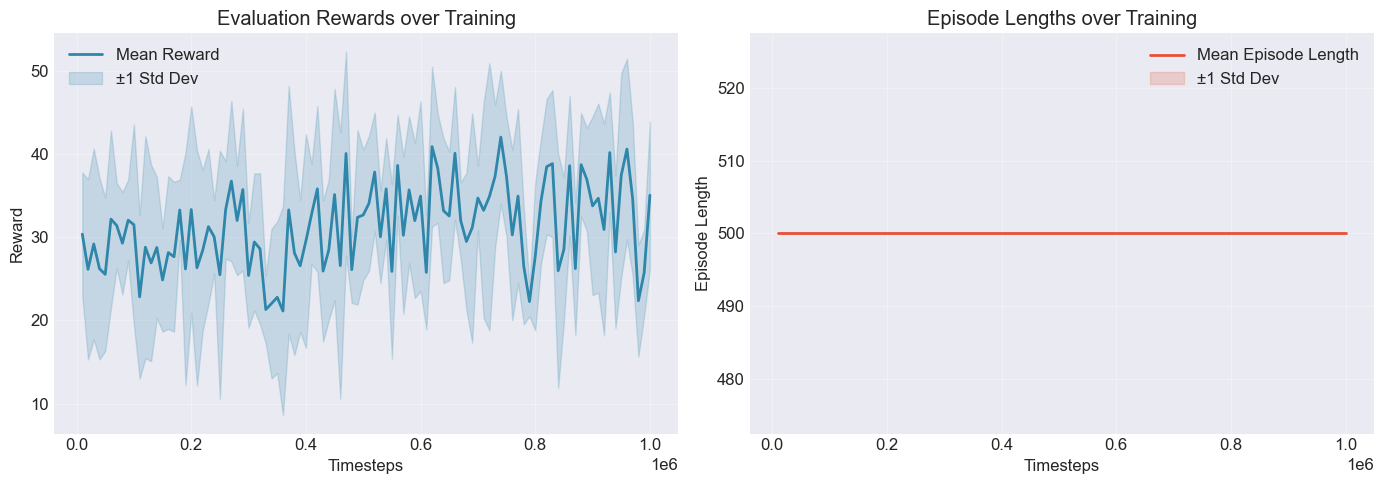


=== Evaluation Summary ===
Total evaluation points: 100
Timestep range: 10,000 to 1,000,000

Rewards:
  Final mean reward: 35.08 ± 8.87
  Best mean reward: 42.08 at timestep 740,000

Episode Lengths:
  Final mean length: 500.00 ± 0.00
  Longest mean episode: 500.00 at timestep 10,000


In [8]:
# Calculate mean and std for rewards and episode lengths
mean_rewards = np.mean(results, axis=1)
std_rewards = np.std(results, axis=1)
mean_ep_lengths = np.mean(ep_lengths, axis=1)
std_ep_lengths = np.std(ep_lengths, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot rewards
ax1 = axes[0]
ax1.plot(timesteps, mean_rewards, color='#2E86AB', linewidth=2, label='Mean Reward')
ax1.fill_between(timesteps, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                  color='#2E86AB', alpha=0.2, label='±1 Std Dev')
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Reward')
ax1.set_title('Evaluation Rewards over Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot episode lengths
ax2 = axes[1]
ax2.plot(timesteps, mean_ep_lengths, color='#E94F37', linewidth=2, label='Mean Episode Length')
ax2.fill_between(timesteps, mean_ep_lengths - std_ep_lengths, mean_ep_lengths + std_ep_lengths,
                  color='#E94F37', alpha=0.2, label='±1 Std Dev')
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Episode Length')
ax2.set_title('Episode Lengths over Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Evaluation Summary ===")
print(f"Total evaluation points: {len(timesteps)}")
print(f"Timestep range: {timesteps[0]:,} to {timesteps[-1]:,}")
print(f"\nRewards:")
print(f"  Final mean reward: {mean_rewards[-1]:.2f} ± {std_rewards[-1]:.2f}")
print(f"  Best mean reward: {np.max(mean_rewards):.2f} at timestep {timesteps[np.argmax(mean_rewards)]:,}")
print(f"\nEpisode Lengths:")
print(f"  Final mean length: {mean_ep_lengths[-1]:.2f} ± {std_ep_lengths[-1]:.2f}")
print(f"  Longest mean episode: {np.max(mean_ep_lengths):.2f} at timestep {timesteps[np.argmax(mean_ep_lengths)]:,}")